# 对 ViT 模型进行知识蒸馏

Now we will apply Knowledge Distillation techniques to the [oxford-pets](https://huggingface.co/datasets/pcuenq/oxford-pets) dataset, a datset with *37 classes of dogs and cats*.

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    ViTConfig,
    ViTForImageClassification,
)
from transformers import ViTImageProcessor, ViTConfig, ViTForImageClassification
from transformers import TrainingArguments, Trainer
import evaluate

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

We will be distilling the knowledge from ```asusevski/vit-base-patch16-224-oxford-pets```, a fine-tuned model based on ```google/vit-base-patch16-224``` into a randomized ```WinKawaks/vit-tiny-patch16-224``` model. Note that the fine-tuned ViT model that will be our teacher model was trained on this dataset already, achieving about **93%** accuracy!

First, lets see the teacher in action:

In [3]:
dataset = load_dataset("pcuenq/oxford-pets")
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 7390
    })
})

In [4]:
id2label = {
    int_label: str_label
    for int_label, str_label in enumerate(sorted(list(set(dataset["train"]["label"]))))
}
label2id = {
    str_label: int_label
    for int_label, str_label in enumerate(sorted(list(set(dataset["train"]["label"]))))
}

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model_name = "asusevski/vit-base-patch16-224-oxford-pets"
teacher_model = AutoModelForImageClassification.from_pretrained(teacher_model_name).to(
    device
)
teacher_model.eval()
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
accuracy = evaluate.load("accuracy")

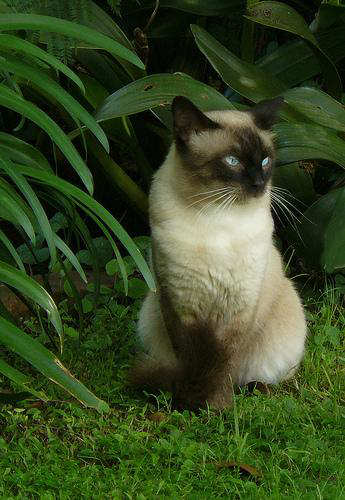

In [6]:
dataset["train"][0]["image"]

In [7]:
inputs = processor(
    dataset["train"][0]["image"], return_tensors="pt"
)  # Here, using default processor on the image

inputs = {
    key: value.to(device) for key, value in inputs.items()
}  # Converting to a dictionary

model_logits = teacher_model(**inputs).logits
model_prediction = torch.argmax(model_logits, dim=1).item()
print(id2label[model_prediction])

Siamese


The model was able to infer that this was a Siamese cat, and a stunning one at that.

This is a great time to dive into *how* we will be using the teacher model's prior knowedge to teach a student model with knowledge distillation.

What we're doing when we perform Knowledge Distillation is, for a given image, trying to get the student model's distribution to mimic that of the Teacher's distribution over all the classes.

Some of the key terms you will encounter are:
- ```temperature```
- ```KL Divergence```
- ```lambda parameter```

Lets start by explaining ```temperature```.

**Temperature** is a hyperparameter that controls the importance of each soft target. Soft target is a term for the teachers' distribution over the output classes, since they are precisely what our student wants to *approach*. A larger temperature will result in a higher loss, thus penalizing the student model further.

Lets look at the teacher's distribution over the classes and then modify the distribution with 2 examples:
- a "low" temperature of 2
- a "high" temperature of 8.

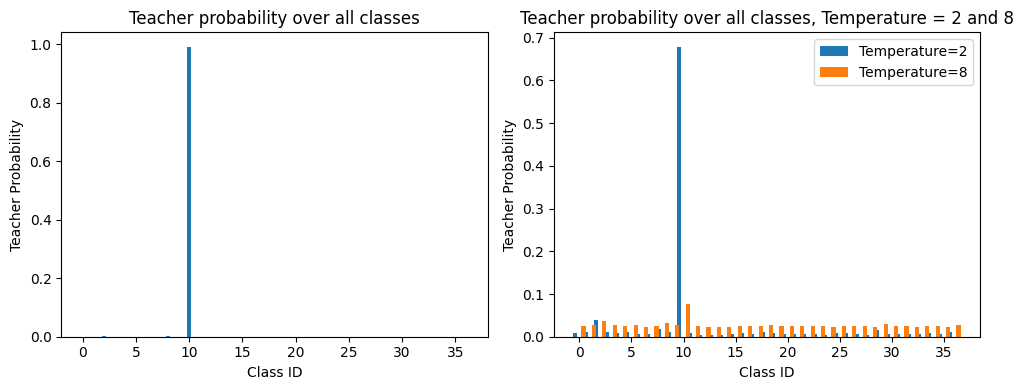

In [8]:
temperature_no_change = 1
low_temperature = 2
high_temperature = 8

teacher_distribution = (
    F.softmax(model_logits / temperature_no_change, dim=-1)
    .cpu()
    .detach()
    .numpy()
    .reshape(-1)
)
teacher_distribution_low_temp = (
    F.softmax(model_logits / low_temperature, dim=-1).cpu().detach().numpy().reshape(-1)
)
teacher_distribution_high_temp = (
    F.softmax(model_logits / high_temperature, dim=-1)
    .cpu()
    .detach()
    .numpy()
    .reshape(-1)
)


fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].bar(id2label.keys(), teacher_distribution, width=0.4)
axs[0].set_title("Teacher probability over all classes")
axs[0].set_ylabel("Teacher Probability")
axs[0].set_xlabel("Class ID")

axs[1].bar(
    np.fromiter(id2label.keys(), dtype=float) - 0.4,
    teacher_distribution_low_temp,
    width=0.4,
    label="Temperature=2",
)
axs[1].bar(
    np.fromiter(id2label.keys(), dtype=float) + 0.4,
    teacher_distribution_high_temp,
    width=0.4,
    label="Temperature=8",
)
axs[1].set_title("Teacher probability over all classes, Temperature = 2 and 8")
axs[1].set_ylabel("Teacher Probability")
axs[1].set_xlabel("Class ID")
axs[1].legend()
plt.tight_layout()
plt.show()

As we can see, a higher temperature sort of smoothes out the distribution, making the probabilities easier to learn from.

Next, we have ```KL Divergence```.

**KL Divergence** is a measure of how similar/dissimilar two probability distributions are. It quantifies how much information is lost when one distribution (our student) is used to approximate the other. If it is 0, then in the case of knowledge distillation, that would mean the student has nothing left to learn from the teacher.

Finally, we have the ```lambda parameter```.

**Lambda parameter** is a weight applied to the overall loss functions terms. There are two terms -- the distillation loss (which comes from the KL-Divergence, as discussed above), and the students' own loss on the dataset. We take a linear combination of these terms, weighted by lambda, and that is our overall loss.

Now we have to prepare the data for ingestion by the HuggingFace Trainer. We prepared the inputs by using the ```ViTImageProcessor``` class above, but we also need to preprare the labels for training. These transforms will be written in the function ```transforms``` and we will map the transforms to each observation in the dataset.

In [9]:
def transforms(example):
    # Convert to RGB - there are some example in the Oxford Pets dataset that are RGBA, and even at least one gif
    example["image"] = example["image"].convert("RGB")

    # Feed image into ViT image processor
    inputs = processor(example["image"], return_tensors="pt")

    # Add to example
    example["pixel_values"] = inputs["pixel_values"].squeeze()
    example["label"] = label2id[example["label"]]
    return example

In [10]:
transformed_dataset = dataset.map(transforms)
transformed_dataset.set_format("pt", columns=["pixel_values"], output_all_columns=True)

In [11]:
def collate_fn(batch):
    return {
        "pixel_values": torch.cat(
            [x["pixel_values"].unsqueeze(dim=0) for x in batch], dim=0
        ),
        "labels": torch.tensor([x["label"] for x in batch]),
    }

Splitting the dataset into train, validation, and test sets:

In [12]:
train_test_dataset = transformed_dataset["train"].train_test_split(test_size=0.2)
train_val_dataset = train_test_dataset["train"].train_test_split(test_size=(0.1 / 0.8))
train_test_valid_dataset = DatasetDict(
    {
        "train": train_val_dataset["train"],
        "valid": train_val_dataset["test"],
        "test": train_test_dataset["test"],
    }
)

First, as a baseline model, we'll fine-tune ```WinKawaks/vit-tiny-patch16-224``` for 5 epochs on the same training data to get an idea of what the performance would look like!

For this, we'll rely on HuggingFace's Trainer API. We need
1. Our base model
2. ```Training Arguments```
3. A compute_metrics function
4. Our final ```Trainer``` object

Initializing a randomized ```WinKawaks/vit-tiny-patch16-224``` model here, we only need to pass a ```ViTConfig``` object to the ```ViTForImageClassification``` class. We'll also modify the config for our specific use-case by adding the number of labels required (so the classifier head is appropriately configued) and the mappings from ids to labels.

In [13]:
config = ViTForImageClassification.from_pretrained(
    "WinKawaks/vit-tiny-patch16-224"
).config
config.id2label = id2label
config.label2id = label2id
config.num_labels = len(id2label)
base_model = ViTForImageClassification(config).to(device)

Next, we'll configure our arguments. Here is where we will also push our fine-tuned model to the HuggingFace Hub (we have to log in first)

In [14]:
training_args = TrainingArguments(
    output_dir="logs/oxford-pets-vit-from-scratch",
    per_device_train_batch_size=48,
    per_device_eval_batch_size=48,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=10,
    learning_rate=3e-4,
    push_to_hub=False,
    load_best_model_at_end=True,
)

Defining our compute metrics function -- we'll leave it at just accuracy for the purposes of this demo, but you can add others if you so choose. We'll re-use this later for when we train a model through Knowledge Distillation.

In [15]:
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    acc = accuracy.compute(
        references=labels, predictions=np.argmax(predictions, axis=1)
    )
    return {"accuracy": acc["accuracy"]}

And finally our ```Trainer``` object!

In [16]:
trainer = Trainer(
    model=base_model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_test_valid_dataset["train"],
    eval_dataset=train_test_valid_dataset["test"],
    processing_class=processor,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


[2024-11-30 16:18:23,710] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio
collect2: error: ld returned 1 exit status
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlopen'
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlclose'
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlerror'
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlsym'
collect2: error: ld returned 1 exit status


Now for the most satisfying part of any HuggingFace Project -- calling ```trainer.train()```

In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,3.634100,3.599328,0.039242
2,3.598200,3.597016,0.038566
3,3.555600,3.545958,0.043302
4,3.528000,3.509003,0.053451
5,3.494800,3.455078,0.075778
6,3.437100,3.440895,0.079161
7,3.424800,3.407156,0.084574
8,3.360700,3.373188,0.087957
9,3.329900,3.360177,0.097429
10,3.304500,3.347142,0.099459


TrainOutput(global_step=1080, training_loss=3.450747511121962, metrics={'train_runtime': 1054.0362, 'train_samples_per_second': 49.078, 'train_steps_per_second': 1.025, 'total_flos': 2.5843921435035648e+17, 'train_loss': 3.450747511121962, 'epoch': 10.0})

In [18]:
trainer.evaluate(train_test_valid_dataset["test"])

{'eval_loss': 3.347142219543457,
 'eval_accuracy': 0.09945872801082543,
 'eval_runtime': 17.2216,
 'eval_samples_per_second': 85.823,
 'eval_steps_per_second': 1.8,
 'epoch': 10.0}

With just training a randomly initialized ViT on the dataset for 10 epochs, the model reaches around 11.6% accuracy. Note that since there are 37 classes, this is a vast improvement over a dummy classifier that picks at random, which we would expect to achieve around 2.7% accuracy.

Now, lets initialize another ViT from scratch and train **with Knowledge Distillation**:

In [19]:
student_model = ViTForImageClassification(config).to(device)

The main modification we will make here is that we're calling a modified ```ImageDistilTrainer``` that inherits from the parent ```Trainer``` class. We need to *overwrite* the loss function so that its representative of the distillation loss function we discussed previously.

Recall, the final loss is a weighted average of the standard cross-entropy loss and the distillation loss, weighted by ```lambda_param```.

In [25]:
class ImageDistilTrainer(Trainer):
    def __init__(
        self,
        teacher_model=None,
        student_model=None,
        temperature=None,
        lambda_param=None,
        *args,
        **kwargs
    ):
        super().__init__(model=student_model, *args, **kwargs)
        self.teacher = teacher_model
        self.student = student_model
        self.loss_function = nn.KLDivLoss(reduction="batchmean")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.teacher.to(device)
        self.teacher.eval()
        self.temperature = temperature
        self.lambda_param = lambda_param

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        student_output = model(**inputs)

        with torch.no_grad():
            teacher_output = self.teacher(**inputs)

        # Compute soft targets for teacher and student
        soft_teacher = F.softmax(teacher_output.logits / self.temperature, dim=-1)
        soft_student = F.log_softmax(student_output.logits / self.temperature, dim=-1)

        # Compute the loss
        distillation_loss = self.loss_function(soft_student, soft_teacher) * (
            self.temperature**2
        )

        # Compute the true label loss
        student_target_loss = student_output.loss

        # Calculate final loss
        loss = (
            1.0 - self.lambda_param
        ) * student_target_loss + self.lambda_param * distillation_loss
        return (loss, student_output) if return_outputs else loss

The rest is largely the same; initialize our ```TrainingArguments``` and our ```ImageDistilTrainer``` instead of the ```Trainer``` object.

In [26]:
training_args = TrainingArguments(
    output_dir="logs/oxford-pets-vit-with-kd",
    per_device_train_batch_size=48,
    per_device_eval_batch_size=48,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=10,
    learning_rate=3e-4,
    push_to_hub=False,
    load_best_model_at_end=True,
)

Note that the authors Hinton et. al found that it was best to use a value of ```lambda_param``` that would place greater weight on the distillation loss. In our case, this corresponds to  ```lambda_param``` being closer to 1 than to 0. 

So, proceeding with ```lambda_param=0.9```, we'll initialize our custom ```ImageDistilTrainer``` below.

In [27]:
teacher_model.eval()
trainer = ImageDistilTrainer(
    student_model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_test_valid_dataset["train"],
    eval_dataset=train_test_valid_dataset["test"],
    processing_class=processor,
    temperature=5,
    lambda_param=0.9,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Train!!!

In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,3.788500,3.799925,0.040595
2,3.733500,3.765554,0.048714
3,3.702100,3.757664,0.053451
4,3.670100,3.714813,0.081867
5,3.625800,3.666038,0.088633
6,3.563400,3.645930,0.088633
7,3.531400,3.602929,0.105548
8,3.470300,3.584462,0.118403
9,3.435900,3.551005,0.119756
10,3.386600,3.538868,0.130582


TrainOutput(global_step=1080, training_loss=3.571450353551794, metrics={'train_runtime': 2869.1366, 'train_samples_per_second': 18.03, 'train_steps_per_second': 0.376, 'total_flos': 2.5843921435035648e+17, 'train_loss': 3.571450353551794, 'epoch': 10.0})

In [29]:
trainer.evaluate(train_test_valid_dataset["test"])

{'eval_loss': 3.538867950439453,
 'eval_accuracy': 0.13058186738836267,
 'eval_runtime': 55.0609,
 'eval_samples_per_second': 26.843,
 'eval_steps_per_second': 0.563,
 'epoch': 10.0}

Hooray! Our little student model has learned so much in such a short period of time. It achieves 13.8% on the test set, outperforming the baseline performance of the vit model that was trained with a standard loss function!

If you want to check out any of the models in this notebook, please refer to the following:
- Teacher model: ```asusevski/vit-base-patch16-224-oxford-pets```
- Randomized ViT trained on dataset: ```asusevski/oxford-pets-vit-from-scratch```
- Randomized ViT trained with Knowledge Distillation: ```asusevski/oxford-pets-vit-with-kd```